## initial mapping workflow for supratidal forests (STF)
- works on geojson GA coastal tiles `../data/geojson/ga_summary_grid_c3_coastal.geojson`
- select `time_range` and if to `export` results as tif

In [1]:
%matplotlib inline

import sys
from osgeo import gdal
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
# pd.set_option('display.max_rows', None)

sys.path.insert(1, "/home/jovyan/code/dea-notebooks/Tools")
import datacube
from dea_tools.plotting import display_map
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
dc = datacube.Datacube()

# load virtual product
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/virtual_product_cat_wcf.yaml')



## user inputs: tile, time and export geotiffs?

In [2]:
# add time (not a range, just repeat year input here)
time_range = ("2020", "2020")

# export as geotiff?
export = True

### using GA coastal tiles geojson

In [3]:
# GA coastal tiles
vector_file = '../data/geojson/ga_summary_grid_c3_coastal.geojson'
attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)
mainland_grid = gdf[gdf['type'] == 'mainland']

id_list = []
for index, row in mainland_grid.iterrows():
    id_list.append(row['id'])
mainland_grid.explore()

### select the tile of interest (click on map above and find value for `id` and manually select using `loc` below)

In [30]:
gdf = mainland_grid.loc[mainland_grid['id'] == 105]

In [31]:
gdf.explore()

In [32]:
# Create the 'query' dictionary object
res = (-30, 30)

query = {
    "time": time_range,
    'resolution':res}

In [33]:
# Loop through polygons in geodataframe and add geom to queries
for index, row in gdf.iterrows():
    print(f'Feature: {index + 1}/{len(gdf)}')
    
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

# Extracting specific keys from dictionary (removing time to load things like item and srtm)
query_notime = {key: query[key] for key in query.keys()
       & {'resolution', 'geopolygon'}}

Feature: 105/1


### load strm

In [34]:
# Load STRM
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', output_crs="EPSG:3577", **query_notime)
srtm = srtm_ds.dem_h

In [35]:
srtm_ds.squeeze().time.values

numpy.datetime64('2014-12-15T14:58:44.000000000')

In [60]:
variable = 'dem_h'
srtm_ds[variable]

<xarray.DataArray 'dem_h' (time: 1, y: 3201, x: 3201)>
array([[[-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        [-3.40282347e+38, -3.40282347e+38, -3.40282347e+38, ...,
         -3.40282347e+38, -3.40282347e+38, -3.40282347e+38],
        ...,
        [ 2.53493723e-04,  4.08706488e-03,  9.48840473e-03, ...,
          9.01002407e+00,  8.68986607e+00,  8.51650715e+00],
        [ 1.49706332e-03,  6.01835642e-03,  1.21096540e-02, ...,
          8.68964386e+00,  8.67216015e+00,  8.76939297e+00],
        [ 2.80697690e-03,  7.98362680e-03,  1.46627175e-02, ...,
          8.80201626e+00,  8.85281849e+00,  8.97931385e+00]]],
      dtype=float32)
Coordinates:
  * time         (time) datetime64[ns] 2014-12-15T14:58:44
  * y            (y) float64 -1.824e+06 -1.824e+06 ... -1.92e+06 -1.92e+06
  * x            (x) float64 8.64e+05 8.64e+05 8.64e+05 ... 9.6e+05 9.6e+05
    spatial_ref  int32 3577
Attributes:
    units:         metre
    nodata:        -340282346638528859811704183484516925440
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [36]:
from pandas import to_datetime
to_datetime(srtm_ds.dem.time.values).values

array(['2014-12-15T14:58:44.000000000'], dtype='datetime64[ns]')

In [37]:
import terrain

In [38]:
shadows, slope, sia = terrain.shadows_and_slope(srtm_ds.squeeze(), srtm_ds.dem.time.values)
# shadows_and_slope(tile, time, no_data=-1000)

# shadows, slope, sia = terrain.shadows_and_slope(
#         dsm, nbar.blue.time.values, no_data=no_data
#     )

In [39]:
sia

array([[17.95742 , 17.95742 , 17.95742 , ..., 17.95742 , 17.95742 ,
        17.95742 ],
       [17.95742 , 17.95742 , 17.95742 , ..., 17.95742 , 17.95742 ,
        17.95742 ],
       [17.95742 , 17.95742 , 17.95742 , ..., 17.95742 , 17.95742 ,
        17.95742 ],
       ...,
       [17.95742 , 17.95742 , 17.95742 , ..., 18.549255, 17.941093,
        17.804108],
       [17.95742 , 17.95742 , 17.95742 , ..., 17.900497, 19.152733,
        18.596245],
       [17.95742 , 17.95742 , 17.95742 , ..., 17.315102, 20.396828,
        20.111671]], dtype=float32)

In [52]:
srtm_ds.squeeze()

<xarray.Dataset>
Dimensions:      (y: 3201, x: 3201)
Coordinates:
    time         datetime64[ns] 2014-12-15T14:58:44
  * y            (y) float64 -1.824e+06 -1.824e+06 ... -1.92e+06 -1.92e+06
  * x            (x) float64 8.64e+05 8.64e+05 8.64e+05 ... 9.6e+05 9.6e+05
    spatial_ref  int32 3577
Data variables:
    dem          (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 9.384 10.38 10.37 7.356
    dem_s        (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 9.441 9.443 9.292 9.029
    dem_h        (y, x) float32 -3.403e+38 -3.403e+38 -3.403e+38 ... 8.853 8.979
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [53]:
slope_xr = xr.DataArray(data=slope, coords=srtm_ds.squeeze().coords, dims=srtm_ds.squeeze().dims, attrs=srtm_ds.squeeze().attrs)

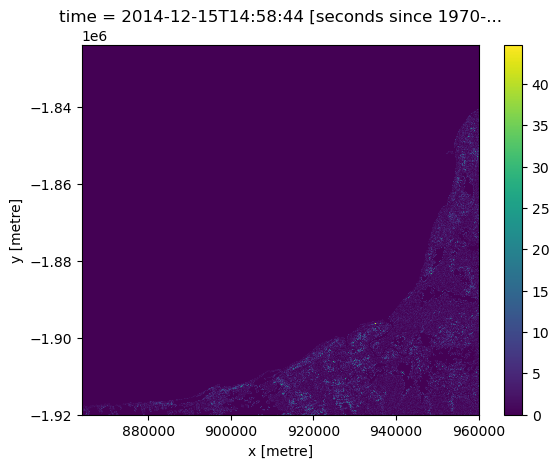

In [55]:
slope_xr.plot()

In [ ]:


# Load item
item_ds = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_notime)
item = item_ds.relative

# Load in mangrove cover
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query)

# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)

### load in woody cover virtual product

In [ ]:
# load in vp woody cover
sys.path.insert(1, '../virtual_products') 
# The dictionary which datacube uses to understand (resolve) the different virtual product functionality
# Need to add any aggregations for the VP you're using

# Get location of transformation
aggregation = "best_pixel_gmad"
agg_loc = importlib.import_module(aggregation)
agg_class = aggregation.split('.')[-1]

DEFAULT_RESOLVER.register('aggregate', agg_class, getattr(agg_loc, agg_class) )

In [ ]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = "woody_cover"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [ ]:
# load woody_cover vp
product = catalog['woody_cover']
woody_cover_vp = product.load(dc, **query)

# # woody cover with threshold for saltmarsh
woody_cover = xr.where(woody_cover_vp.woody_cover > 0.5, 1, 0).astype('int8')
woody_cover.attrs['crs'] = 'EPSG:3577'

### create initial supratidal forest extent product

In [ ]:
## wrangle binary maps and create STF mask

# not mangrove == True
not_mangrove = (1 - mangrove)
not_mangrove = not_mangrove == 1

# greater than 1m AHD and less than 10m AHD == True
AHD_min = 1
AHD_max = 10

# SRTM
lessthan10m_AHD = srtm <= AHD_max
greaterthan1m_AHD = srtm >= AHD_min
AHD_threshold_srtm = lessthan10m_AHD & greaterthan1m_AHD

# item (remove all intertidal areas)
not_intertidal = item == 9

# remove time dim
not_mangrove = not_mangrove.squeeze('time')
AHD_threshold_srtm = AHD_threshold_srtm.squeeze('time')
not_intertidal = not_intertidal.squeeze('time')

In [ ]:
# combine masks
STF = xr.where((not_mangrove == False) + (AHD_threshold_srtm == False) + (not_intertidal == False) + (woody_cover == False), 0, 1).astype('int8')

In [ ]:
# Generate a polygon mask to keep only data within the polygon
mask = xr_rasterize(gdf, srtm_ds)

# Mask dataset to set pixels outside the polygon to `NaN`
STF = STF.where(mask)

### combine inputs and output to 7 band xarray dataset
- band 1: mangrove (1), no mangrove (0)
- band 2: SRTM data (raw elevation values)
- band 3: SRTM threshold between 1-10 (1), outside this range (0)
- band 4: ITEMs intertidal areas (1), non intertidal areas (0)
- band 5: woody cover fraction data (raw fraction values 0-1)
- band 6: woody cover fraction threshold >0.5 (1), <0.5 (0)
- band 7: STF present (1), STF absent (0)

In [ ]:
STF.plot()

In [ ]:
# make all into datasets and merge
variables_xarray_list = []

# band 1
mangrove_ds = mangrove.to_dataset(name="mangrove").squeeze().drop('time')
variables_xarray_list.append(mangrove_ds)

# band 2
srtm_false_value_remove = xr.where(srtm < -10 ,0, srtm.values)
srtm_ds = srtm_false_value_remove.to_dataset(name="SRTM").squeeze().drop('time')
variables_xarray_list.append(srtm_ds)

# band 3
AHD_threshold_srtm_ds = AHD_threshold_srtm.to_dataset(name="SRTM_threshold").squeeze().drop('time')
variables_xarray_list.append(AHD_threshold_srtm_ds)

# band 4
intertidal = xr.where(not_intertidal == True, 0, 1).astype('int8')
intertidal_ds = intertidal.to_dataset(name="intertidal_and_below").squeeze().drop('time')
variables_xarray_list.append(intertidal_ds)

# band 5
woody_cover_raw = woody_cover_vp.woody_cover
woody_cover_raw_mask_intertidal = woody_cover_raw.where(not_intertidal) # mask by intertidal due to WCF values in water that are erronous (note this means areas in the intertidal are not masked for WCF, which we actually may want to know about for STF vs saltmarsh)
woody_cover_raw_mask_intertidal_ds = woody_cover_raw_mask_intertidal.to_dataset(name="woody_cover").squeeze()
variables_xarray_list.append(woody_cover_raw_mask_intertidal_ds)

# band 6
woody_cover_threshold_ds = woody_cover.to_dataset(name="woody_cover_threshold").squeeze()
variables_xarray_list.append(woody_cover_threshold_ds)

# band 7
STF_ds = STF.to_dataset(name="STF")#.squeeze().drop('time')
variables_xarray_list.append(STF_ds)

stacked_xarray = xr.merge(variables_xarray_list)

### output to geotiff

In [ ]:
def set_band_names(input_img: str, band_names: list, feedback: bool = False):
    """
    NOTE: Function is from RSGISlib that is not avaliable on DEA sandbox
    A utility function to set band names.

    :param input_img: input image file.
    :param band_names: is a list of band names
    :param feedback: is a boolean specifying whether feedback will be printed to the
                     console (True= Printed / False (default) Not Printed)

    .. code:: python

        from rsgislib import imageutils

        input_img = 'injune_p142_casi_sub_utm.kea'
        band_names = ['446nm','530nm','549nm','569nm','598nm','633nm','680nm','696nm',
                      '714nm','732nm','741nm','752nm','800nm','838nm']

        imageutils.set_band_names(input_img, band_names)

    """
    dataset = gdal.Open(input_img, gdal.GA_Update)

    for i in range(len(band_names)):
        band = i + 1
        bandName = band_names[i]

        imgBand = dataset.GetRasterBand(band)
        # Check the image band is available
        if not imgBand is None:
            if feedback:
                print('Setting Band {0} to "{1}"'.format(band, bandName))
            imgBand.SetDescription(bandName)
        else:
            raise rsgislib.RSGISPyException("Could not open the image band: ", band)


In [ ]:
if export == False:
    pass
else:
    write_cog(geo_im=stacked_xarray.to_array(),
              fname='initial_STF_model_coastal_tile_gridID_' + gdf['id'].astype(str).item() +'_year_' + time_range[0] + '.tif',
              overwrite=True,
              nodata=0.0)

    input_img = 'initial_STF_model_coastal_tile_gridID_' + gdf['id'].astype(str).item() +'_year_' + time_range[0] + '.tif'
    band_names = list(stacked_xarray.data_vars.keys())
    set_band_names(input_img, band_names)